# Gaussian Mixture Models

Gaussian Mixture Models assume that your data follows Gaussian (a.k.a. Normal) distribution. Since there can be multiple such distributions within your data, you get to specify their number, which is essentially the number of clusters that you want to have.

Also, since separate distributions can overlap, the model output is not a hard assignment of points to specific clusters. It is based on a probability that the point belongs to a said distribution. Say, if point A has a probability of 0.6 belonging to “Cluster 0” and a probability of 0.4 belonging to “Cluster 1,” then the model would recommend “Cluster 0” to be the label for that point (since 0.6>0.4).

## The EM algorithm

To understand how GMM works in practice, we need to look at the Expectation-Maximization (EM) algorithm. The EM uses an iterative method to calculate and recalculate the parameters of each cluster (distribution), i.e., mean, variance/covariance, and size.

The model initializes a specified number of clusters with a set of parameters that can either be random or specified by the user. Smart initialization options are also available in some implementations (e.g., sklearn’s implementation of GMM by default uses kmeans to initialize clusters).

With clusters initialized, we have the mean (μ), covariance ($\Sigma$), and size (𝜋) available to use.

- Expectation (E-step) — for each data point, a “responsibility” r is calculated, which is, in simple terms, a probability of that data point belonging to a cluster c. This is done for each point with regard to each cluster.
- Maximization (M-step) — then “responsibilities” are used to recalculate the mean, covariance, and size of each cluster (distribution). At this step, you can also think of “responsibility” as a weight. The less likely it is that the data point belongs to a cluster, the smaller the weight it will carry in the recalculation of μ, $\Sigma$, and 𝜋. In the GIF image above, you can see how the position, shape, and size of the clusters change with each iteration.

The process of E-step and M-step is repeated many times until no further improvements can be made, i.e., convergence is achieved.

In [2]:
!pip install geopy

     |████████████████████████████████| 118 kB 563 kB/s eta 0:00:01


In [3]:
import pandas as pd # for data manipulation
import numpy as np # for data manipulation

from sklearn.mixture import GaussianMixture # for GMM clustering
from sklearn import metrics # for calculating Silhouette score

import matplotlib.pyplot as plt # for data visualization
import plotly.express as px  # for data visualization
import plotly.graph_objects as go # for data visualization

from geopy.geocoders import Nominatim # for getting city coordinates
from progressbar import ProgressBar # for displaying progress 
import time # for adding time delays

In [4]:
# Set Pandas options to display more columns
pd.options.display.max_columns=50

# Read in the weather data csv
df=pd.read_csv('weatherAUS.csv', encoding='utf-8')

# Drop records where target RainTomorrow=NaN
df=df[pd.isnull(df['RainTomorrow'])==False]

# For other columns with missing values, fill them in with column mean
df=df.fillna(df.mean())

# Add spaces between multiple words in location names
df['Location2']=df['Location'].str.replace( r"([A-Z])", r" \1").str.strip()
# Update Location for Pearce RAAF so it can be found by geolocator
df['Location2']=df['Location2'].apply(lambda x: 'Pearce, Bullsbrook' if x=='Pearce R A A F' else x)

# Show a snaphsot of data
df

<ipython-input-4-0ee476a87dde>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Location2']=df['Location'].str.replace( r"([A-Z])", r" \1").str.strip()


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Location2
0,2008-12-01,Albury,13.4,22.9,0.6,5.469824,7.624853,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.000000,4.503167,16.9,21.8,No,No,Albury
1,2008-12-02,Albury,7.4,25.1,0.0,5.469824,7.624853,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,4.437189,4.503167,17.2,24.3,No,No,Albury
2,2008-12-03,Albury,12.9,25.7,0.0,5.469824,7.624853,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,4.437189,2.000000,21.0,23.2,No,No,Albury
3,2008-12-04,Albury,9.2,28.0,0.0,5.469824,7.624853,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,4.437189,4.503167,18.1,26.5,No,No,Albury
4,2008-12-05,Albury,17.5,32.3,1.0,5.469824,7.624853,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,No,No,Albury
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,2017-06-20,Uluru,3.5,21.8,0.0,5.469824,7.624853,E,31.0,ESE,E,15.0,13.0,59.0,27.0,1024.7,1021.2,4.437189,4.503167,9.4,20.9,No,No,Uluru
145455,2017-06-21,Uluru,2.8,23.4,0.0,5.469824,7.624853,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,4.437189,4.503167,10.1,22.4,No,No,Uluru
145456,2017-06-22,Uluru,3.6,25.3,0.0,5.469824,7.624853,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,4.437189,4.503167,10.9,24.5,No,No,Uluru
145457,2017-06-23,Uluru,5.4,26.9,0.0,5.469824,7.624853,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,4.437189,4.503167,12.5,26.1,No,No,Uluru


Since our original data only contains location (city) names and not coordinates, we will use Geopy’s Nominatim to get those coordinates. Note that we add a sleep time of 1 second between each call not to overload the server.

In [5]:
# Create a list of unique locations (cities)
loc_list=list(df.Location2.unique())

geolocator = Nominatim(user_agent="add-your-agent-name")
country ="Australia"
loc_res=[]

pbar=ProgressBar() # This will help us to show the progress of our iteration
for city in pbar(loc_list):
    loc = geolocator.geocode(city+','+ country)
    res = [city, loc.latitude, loc.longitude]
    loc_res = loc_res + [res]
    time.sleep(1) # sleep for 1 second before submitting the next query

# Add locations to a dataframe
df_loc=pd.DataFrame(loc_res, columns=['Loc', 'Latitude', 'Longitude'])

# Show data
df_loc

100% |########################################################################|


,Loc,Latitude,Longitude
0,Albury,-36.080477,146.916280
1,Badgerys Creek,-33.881667,150.744163
2,Cobar,-31.498333,145.834444
3,Coffs Harbour,-30.296241,153.113529
4,Moree,-29.461720,149.840715
5,Newcastle,-32.919295,151.779535
6,Norah Head,-33.281667,151.567778
7,Norfolk Island,-29.028958,167.958729
8,Penrith,-33.751079,150.694168
9,Richmond,-20.569655,142.928360


Let's plot this data:

In [7]:
# Create a figure
fig = go.Figure(data=go.Scattergeo(
        lat=df_loc['Latitude'],
        lon=df_loc['Longitude'],
        hovertext=df_loc['Loc'], 
        mode = 'markers',
        marker_color = 'black',
        ))

# Update layout so we can zoom in on Australia
fig.update_layout(
        width=720,
        height=450,
        margin={"r":0,"t":10,"l":0,"b":10},
        geo = dict(
            scope='world',
            projection_type='miller',
            landcolor = "rgb(250, 250, 250)",
            center=dict(lat=-25.69839, lon=139.8813), # focus point
            projection_scale=6 # zoom in on
        ),
    )
fig.show()

There is more than one way to select how many clusters you should have. It can be based on your knowledge of the data or something more data-driven like the Silhouette score.

The Silhouette Coefficient is defined for each sample and is composed of two scores:
- a: The mean distance between a sample and all other points in the same class.
- b: The mean distance between a sample and all other points in the next nearest cluster.

The Silhouette Coefficient s for a single sample is then given as:

$$
s = \frac{b-a}{max(a,b)}
$$

Let’s create multiple GMM models using a different number of clusters and plot Silhouette scores.

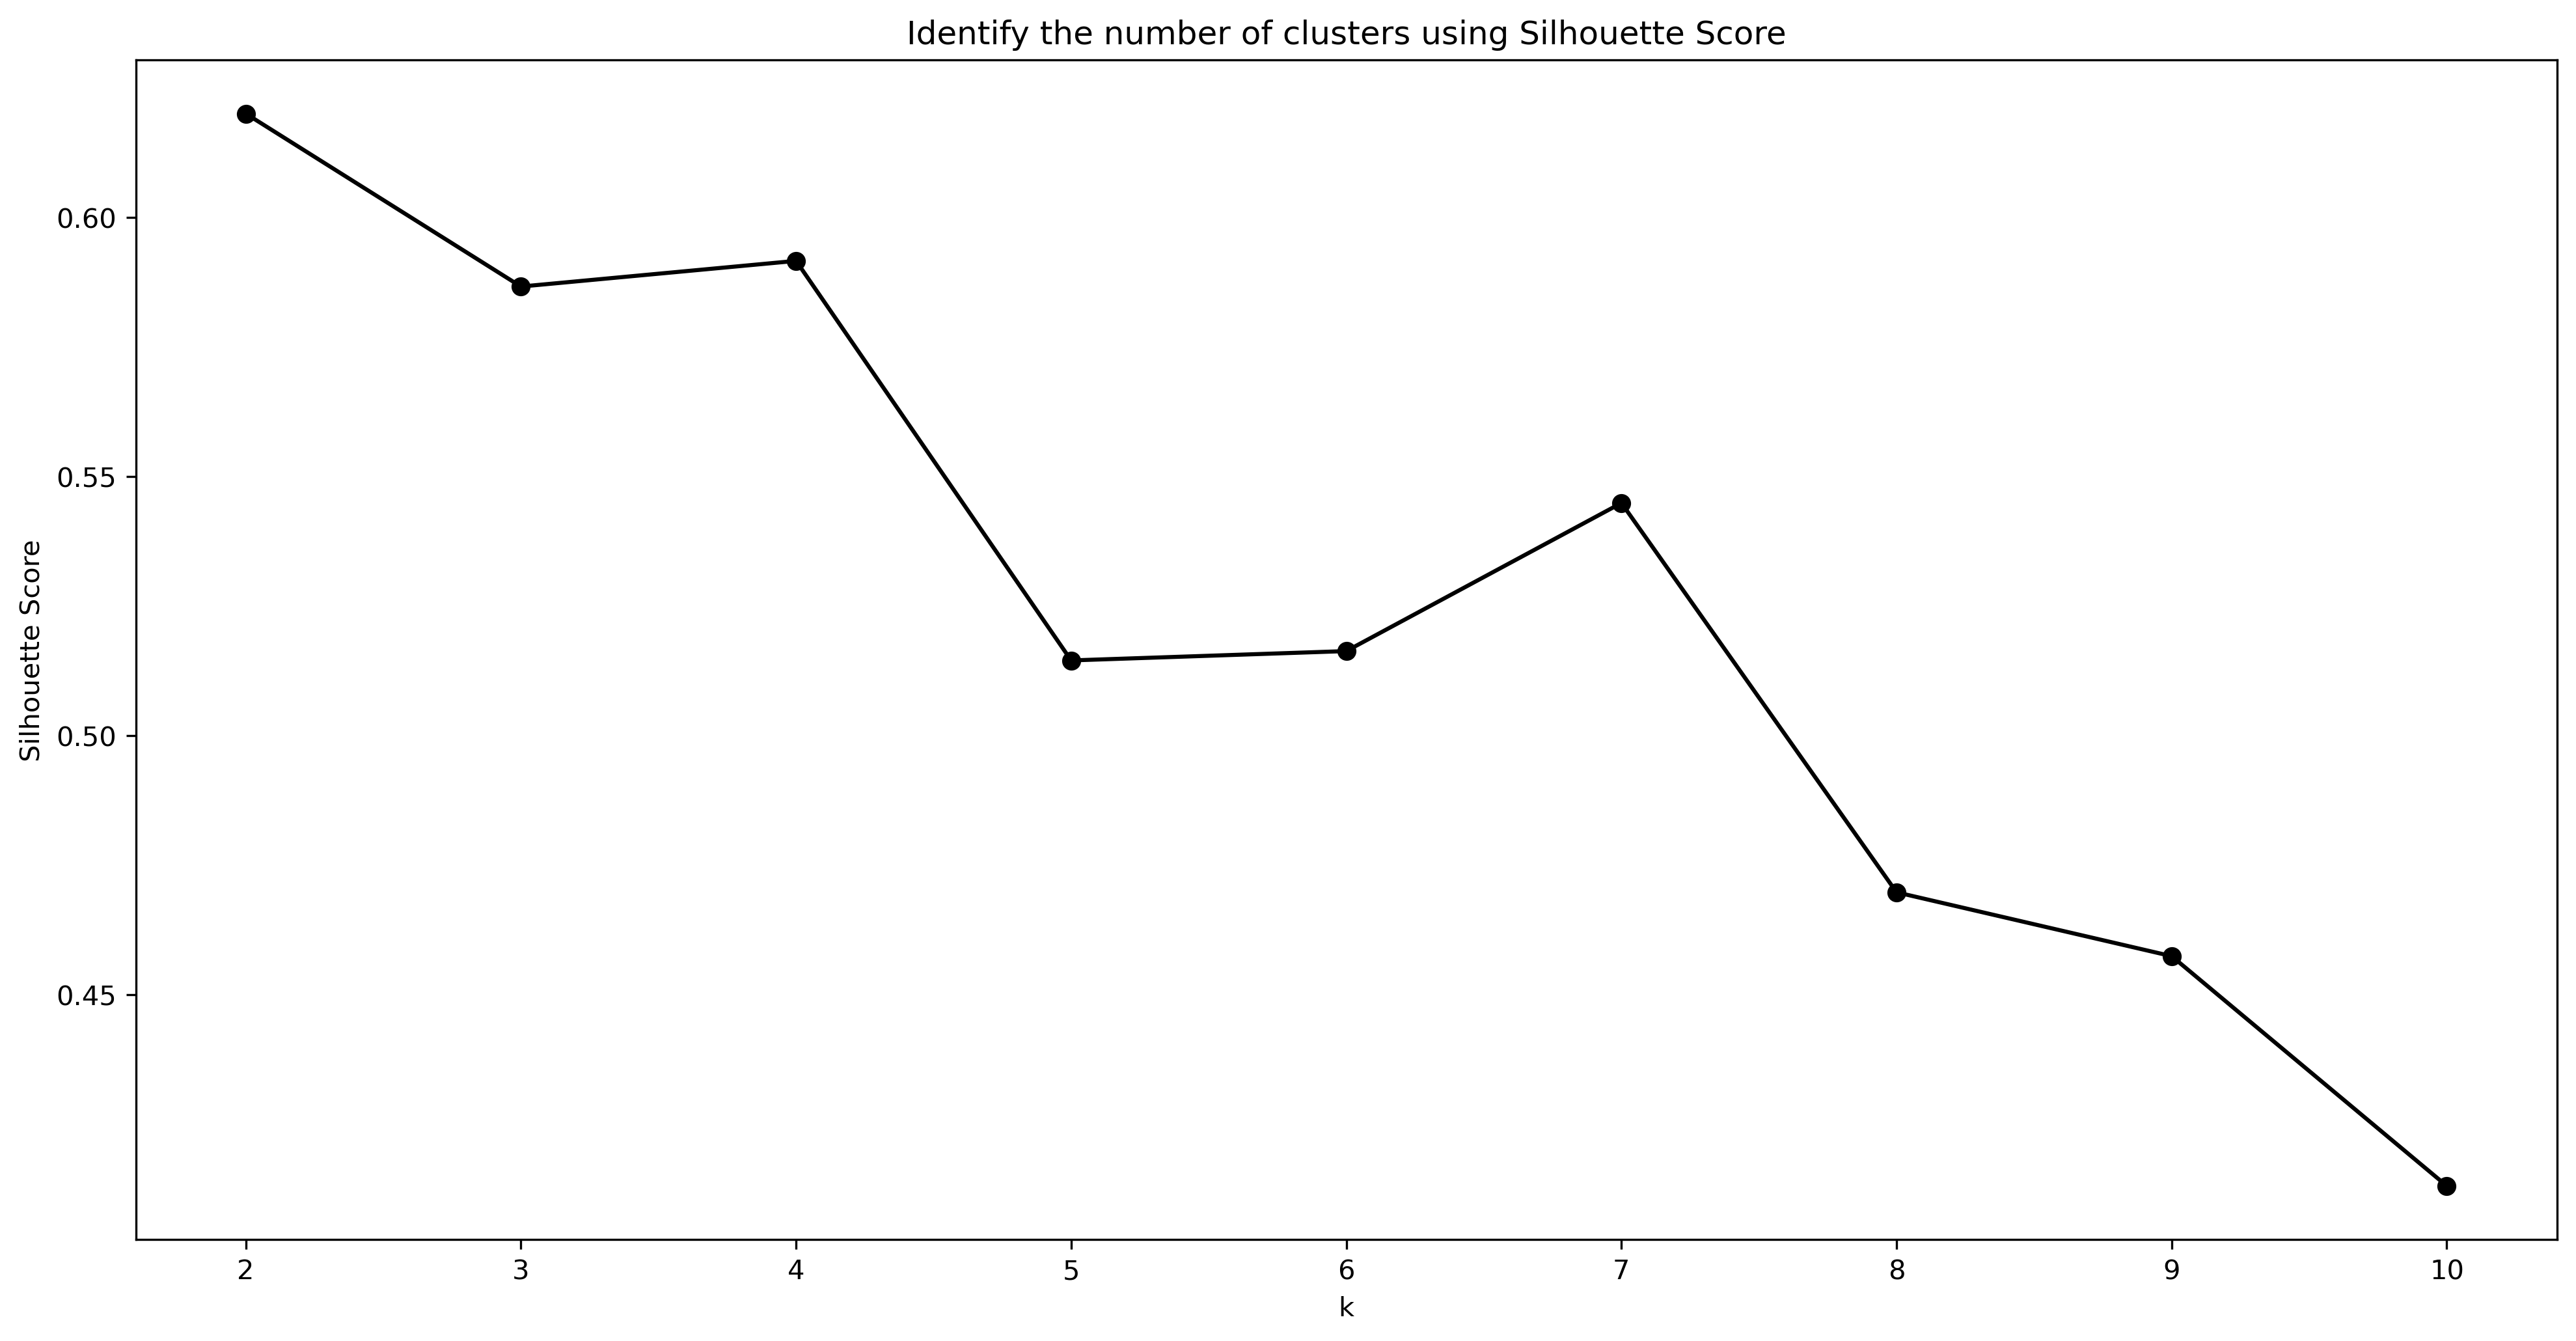

In [8]:
# Create empty list
S=[]

# Range of clusters to try (2 to 10)
K=range(2,11)

# Select data for clustering model
X = df_loc[['Latitude', 'Longitude']]

for k in K:
    # Set the model and its parameters
    model = GaussianMixture(n_components=k, n_init=20, init_params='kmeans')
    # Fit the model 
    labels = model.fit_predict(X)
    # Calculate Silhoutte Score and append to a list
    S.append(metrics.silhouette_score(X, labels, metric='euclidean'))

# Plot the resulting Silhouette scores on a graph
plt.figure(figsize=(16,8), dpi=300)
plt.plot(K, S, 'bo-', color='black')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Identify the number of clusters using Silhouette Score')
plt.show()

Generally, the higher the Silhouette score, the better defined your clusters are. In this example,w we chose to have 4 clusters instead of 2 despite the score being slightly higher for a 2 cluster setup.

## GMM model

In [9]:
# Select data for clustering model
X = df_loc[['Longitude', 'Latitude']]

# Set the model and its parameters - 4 clusters
model4 = GaussianMixture(n_components=4, # this is the number of clusters
                         covariance_type='full', # {‘full’, ‘tied’, ‘diag’, ‘spherical’}, default=’full’
                         max_iter=100, # the number of EM iterations to perform. default=100
                         n_init=1, # the number of initializations to perform. default = 1
                         init_params='kmeans', # the method used to initialize the weights, the means and the precisions. {'random' or default='k-means'}
                         verbose=0, # default 0, {0,1,2}
                         random_state=1 # for reproducibility
                        )

# Fit the model and predict labels
clust4 = model4.fit(X)
labels4 = model4.predict(X)

# Generate 10,000 new samples based on the model
smpl=model4.sample(n_samples=10000)

# Print model summary
print('*************** 4 Cluster Model ***************')
#print('Weights: ', clust4.weights_)
print('Means: ', clust4.means_)
#print('Covariances: ', clust4.covariances_)
#print('Precisions: ', clust4.precisions_)
#print('Precisions Cholesky: ', clust4.precisions_cholesky_)
print('Converged: ', clust4.converged_)
print(' No. of Iterations: ', clust4.n_iter_)
#print('Lower Bound: ', clust4.lower_bound_)

*************** 4 Cluster Model ***************
Means:  [[117.02898335 -33.22539118]
 [150.09499884 -33.46738258]
 [142.61048443 -37.09781308]
 [137.76640859 -19.04726667]]
Converged:  True
 No. of Iterations:  10


Let's plot our clusters:

In [20]:
# Attach cluster labels to the main dataframe
df_loc['Clust4']=labels4

# Create a figure
fig = go.Figure(data=go.Scattergeo(
        lat=df_loc['Latitude'],
        lon=df_loc['Longitude'],
        hovertext=df_loc[['Loc', 'Clust4']], 
        mode = 'markers',
        marker=dict(colorscale=['#ae34eb', 'red', 'blue', '#34eb34']),
        marker_color = df_loc['Clust4'],
        ))

# Update layout so we can zoom in on Australia
fig.update_layout(
        showlegend=False,
        width=760,
        height=400,
        margin={"r":0,"t":30,"l":0,"b":10},
        geo = dict(
            scope='world',
            projection_type='miller',
            landcolor = "rgb(250, 250, 250)",
            center=dict(lat=-25.69839, lon=139.8813), # focus point
            projection_scale=6 # zoom in on
        ),
    )
fig.show()

In [13]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, edgecolor="k", **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2, edgecolor="k")
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

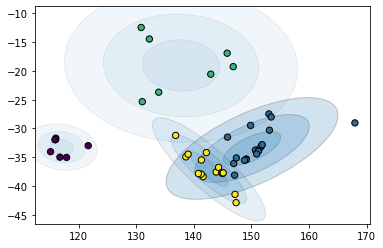

In [19]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X.to_numpy())

Gaussian Mixture Models are useful in situations where clusters have an “elliptical” shape. While K-Means only use means (centroids) to find clusters, GMMs also include variance/covariance. This is exactly what gives GMMs an advantage over K-Means when identifying non-circular clusters.

You can also plot the sample of 10,000 new points generated by the model:

In [12]:
# Create a figure
fig = go.Figure(data=go.Scattergeo(
        lat=smpl[0][:,1],
        lon=smpl[0][:,0],
        mode = 'markers',
        marker=dict(colorscale=['#ae34eb', 'red', 'blue', '#34eb34']),
        marker_color = smpl[1],
        marker_size=3
        ))

# Update layout so we can zoom in on Australia
fig.update_layout(
        showlegend=False,
        width=760,
        height=450,
        margin={"r":0,"t":30,"l":0,"b":10},
        geo = dict(
            scope='world',
            projection_type='miller',
            landcolor = "rgb(250, 250, 250)",
            center=dict(lat=-25.69839, lon=139.8813), # focus point
            projection_scale=6 # zoom in on
        ),
    )
fig.show()